In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
# Load data
query_img = cv.imread('data/1.jpg')
train_img = cv.imread('data/2.jpg')

float32


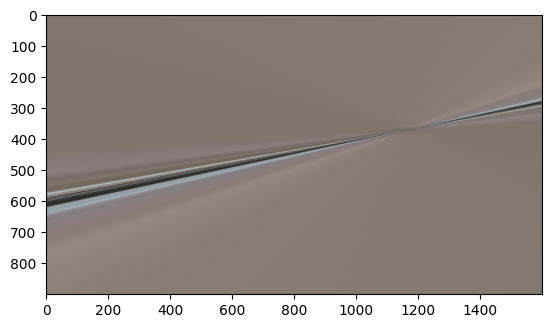

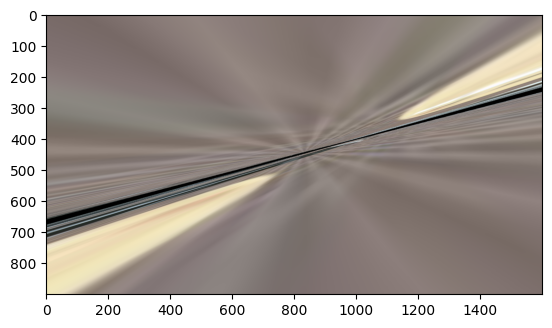

In [27]:
sift = cv.SIFT_create()
# Extract SIFT key points and features
kp1, des1 = sift.detectAndCompute(query_img, None)
kp2, des2 = sift.detectAndCompute(train_img, None)


# Compute matches
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
ratio = 0.5
good_points = []
for m,n in matches:
    distance_ratio = m.distance / n.distance
    if distance_ratio > ratio :
        good_points.append([m, distance_ratio])
 
# sort matches to get 
matches = np.array(good_points)
idx = np.argsort(-matches[:, 1])
matches = matches[idx]

src_pts = []
dst_pts = []
for i, m in enumerate(matches):
    # only take first value because second value is the distance
    src_pts.append(kp1[m[0].queryIdx].pt)
    dst_pts.append(kp2[m[0].trainIdx].pt)
    if i==3:
        break

src_pts = np.array(src_pts).astype(np.float32)
dst_pts = np.array(dst_pts).astype(np.float32)
print(src_pts.dtype)
transform_mat = cv.getPerspectiveTransform(np.array(src_pts), np.array(dst_pts))
dst = cv.warpPerspective(query_img, transform_mat, (query_img.shape[1], query_img.shape[0]))

_, ax = plt.subplots(1, 1)
dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
ax.imshow(dst)


A = []
for s, d in zip(src_pts, dst_pts):
    # maybe x and y need to be swapped
    #s = xy, d = x'y'
    A.append([s[0], s[1], 1, 0, 0, 0, -d[0]*s[0],  -d[0]*s[1], -d[0]])
    A.append([0, 0, 0, s[0], s[1], 1, -d[1]*s[0],  -d[1]*s[1], -d[1]])
A = np.array(A)

U, D, V = np.linalg.svd(A)
eigvals_idx = np.argsort(D)
# take lowest eigval for the eigenvector that is our homography
V = V[eigvals_idx]
H = V[0].reshape(3,3)

# normalize H to sum up to one
H = H * ( 1 / (H**2).sum())


# p_prime = grid * H
cv.imwrite("train_img.jpg", train_img)

query_warp = cv.warpPerspective(query_img, H, (query_img.shape[1], query_img.shape[0]))

cv.imwrite("query_warp.jpg", query_warp)

_, ax = plt.subplots(1, 1)
query_warp = cv.cvtColor(query_warp, cv.COLOR_BGR2RGB)
ax.imshow(query_warp)


In [4]:
# Projection matrixs for query_img and train_img
P_q = np.array([[1.0, 0, 0, 0],
                [0, 1.0, 0, 0],
                [0, 0, 1.0, 0]])

P_t = np.array([[1.0, 0, 0, 1],
                [0, 1.0, 0, 1],
                [0, 0, 1.0, 0]])

# Compute 3D points



In [5]:
# Visualization